In [1]:
import torch
import torch.nn as nn
import torch.utils.data as Data
from torch import optim
import numpy as np
from tqdm import *
import matplotlib.pyplot as plt
import re
import string
from collections import Counter  # 计数类

https://github.com/zll17/Neural_Topic_Models/blob/master/data/zhdd_lines.txt

In [2]:
with open('data/zhdd_lines.txt','r',encoding='utf-8') as f:
    datas = f.readlines()
datas[:10]

['喂，吉姆，晚饭后去喝点啤酒怎么样？ 你知道这很诱人，但对我们的健康真的不好。 什么意思?它会帮助我们放松。 你真的这么认为吗？我没有。这只会让我们变胖，变傻。记得上次吗？ 我想你是对的。但是我们该怎么办呢？我不想坐在家里。 我建议去健身房，在那里我们可以唱歌，还可以认识一些朋友。 这是个好主意。我听说玛丽和莎莉经常去那里打乒乓球。也许我们可以和他们组成一个四人组。 听起来很棒！如果他们愿意，我们可以请他们和我们一起去跳舞。那也是极好的锻炼和乐趣。 很好。我们走吧。 好吧。\n',
 '你会做俯卧撑吗？ 我当然可以。小菜一碟！信不信由你，我一分钟可以做30个俯卧撑。 真的吗？我认为那是不可能的！ 你是说30个俯卧撑？ 耶！ 很简单。如果你每天锻炼，你也能做到。\n',
 '你能开着收音机学习吗？ 不，我听背景音乐。 有什么不同？ 收音机里的新闻太多了。 没错，但是你必须买一台电唱机。\n',
 '你还好吗？ 我很快就会好的。当我看到他们从电线上掉下来时，我吓坏了。 别担心。他是一名杂技演员。 我明白了。\n',
 '嘿，约翰，溜冰鞋不错。它们是新的吗？ 是的，我刚拿到。我开始在社区联盟打冰球。所以，我终于给自己买了新冰鞋。 你打什么位置？ 我是一名后卫。这很有趣。你不必在防守时滑得那么快。 是的，你是个很大的家伙。我自己也打守门员。 是吗？哪个队？ 火箭队。 真的吗？我想我们下周和你们比赛。嗯，我得去练习了。回头见。 好吧，回头见。\n',
 '嘿，莉迪亚，你在看什么？ 我在看我这个月的星座运势！我的前景非常乐观。它说我应该去一个充满异国情调的地方度假，我会有一个充满激情的夏日狂欢！ 你在说什么？让我看看...什么是星座？ 这是根据你的星座对你月份的预测。你出生的月份和日期有不同的符号。我出生于4月15日，所以我是白羊座。你什么时候出生的？ 1月5日。 让我想想。。。你是摩羯。它说你在工作中会感到压力，但是你可以在你的爱情生活中看到新的、令人兴奋的发展。看来我们都会有有趣的夏天！ 那是假的。我在工作中没有感到任何压力，我的爱情生活实际上是不存在的。十二宫杀手的事情都是一派胡言。 不，不是的，你的星座能告诉你很多关于你个性的信息。看到了吗？据说白羊座精力充沛，喜欢社交。 你当然符合这些标准，但它们太宽泛了，可以适用于任何人。它说了我什么？ 摩羯座是一个认真务实的人。

In [3]:
# 查看特殊字符
content = ''.join(datas)
special_char = re.sub(r'[\u4e00-\u9fa5]', '', content)  # 匹配中文，将中文替换掉
print(set(special_char) - set(string.ascii_letters) - set(string.digits))

{'#', ',', '‘', '.', '\\', '…', '、', '！', '?', '@', '-', '&', ':', '’', '，', '+', '·', '×', ')', '？', '。', '《', '“', '~', '；', '/', '"', '”', "'", '—', ' ', '*', '（', '=', '(', '》', '%', '\n'}


In [4]:
def tokenize(datas):
    tokens = []
    for data in datas:
        data = data.strip().replace("\n", "")
        token = []
        for char in data:
            if char == ' ':
                token.append('<sep>')
            else:
                token.append(char)
        token.append('<sep>')
        tokens.append(token)
    return tokens

tokens = tokenize(datas)
print("tokens:", tokens[:6])

tokens: [['喂', '，', '吉', '姆', '，', '晚', '饭', '后', '去', '喝', '点', '啤', '酒', '怎', '么', '样', '？', '<sep>', '你', '知', '道', '这', '很', '诱', '人', '，', '但', '对', '我', '们', '的', '健', '康', '真', '的', '不', '好', '。', '<sep>', '什', '么', '意', '思', '?', '它', '会', '帮', '助', '我', '们', '放', '松', '。', '<sep>', '你', '真', '的', '这', '么', '认', '为', '吗', '？', '我', '没', '有', '。', '这', '只', '会', '让', '我', '们', '变', '胖', '，', '变', '傻', '。', '记', '得', '上', '次', '吗', '？', '<sep>', '我', '想', '你', '是', '对', '的', '。', '但', '是', '我', '们', '该', '怎', '么', '办', '呢', '？', '我', '不', '想', '坐', '在', '家', '里', '。', '<sep>', '我', '建', '议', '去', '健', '身', '房', '，', '在', '那', '里', '我', '们', '可', '以', '唱', '歌', '，', '还', '可', '以', '认', '识', '一', '些', '朋', '友', '。', '<sep>', '这', '是', '个', '好', '主', '意', '。', '我', '听', '说', '玛', '丽', '和', '莎', '莉', '经', '常', '去', '那', '里', '打', '乒', '乓', '球', '。', '也', '许', '我', '们', '可', '以', '和', '他', '们', '组', '成', '一', '个', '四', '人', '组', '。', '<sep>', '听', '起', '来', '很', '棒', '！', '如', '果', '他

In [5]:
len(tokens), max(len(sublist) for sublist in tokens), min(len(sublist) for sublist in tokens), np.mean([len(sublist) for sublist in tokens])

(12336, 1243, 9, 150.01840142671855)

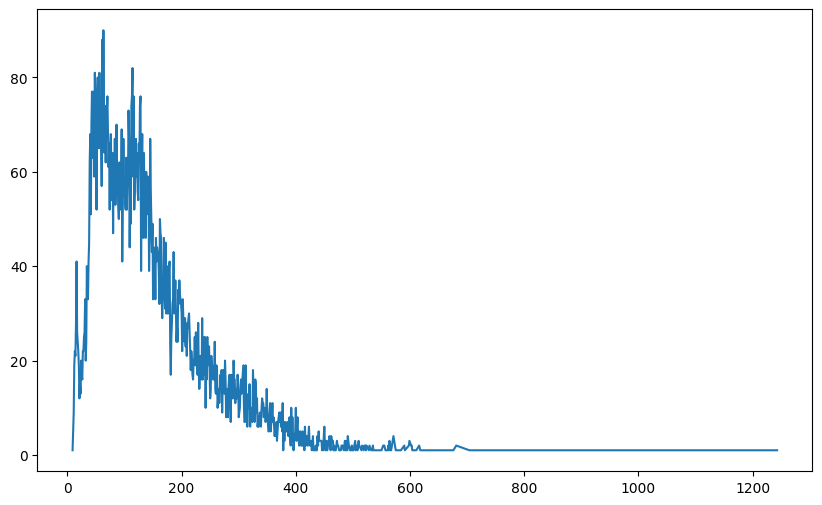

In [6]:
lengths = [len(sublist) for sublist in tokens]
length_freq = Counter(lengths)
x = sorted(length_freq.keys())
y = [length_freq[i] for i in x]
plt.figure(figsize=(10, 6))
plt.plot(x, y)

In [7]:
tokens_ = []
for sequence in tokens:
    if len(sequence) > 500:
        tokens_.append(sequence[:500])
    else:
        tokens_.append(sequence)

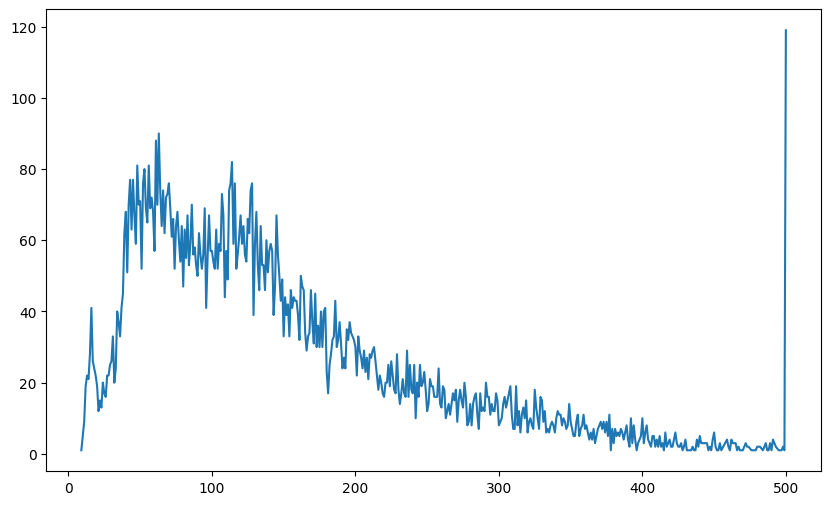

In [8]:
lengths = [len(sublist) for sublist in tokens_]
length_freq = Counter(lengths)
x = sorted(length_freq.keys())
y = [length_freq[i] for i in x]
plt.figure(figsize=(10, 6))
plt.plot(x, y)

In [9]:
tokens = tokens_  

In [10]:
from collections import Counter  #计数类

flatten = lambda l: [item for sublist in l for item in sublist]  #展平数组

# 构建词表
class Vocab:
    def __init__(self, tokens):
        self.tokens = tokens  # 传入的tokens是二维列表
        self.token2index = {'<bos>': 0, '<eos>': 1, '<unk>': 2, '<pad>': 3}  # 先存好特殊词元
        # 将词元按词频排序后生成列表
        self.token2index.update({
            token: index + 4
            for index, (token, freq) in enumerate(
                sorted(Counter(flatten(self.tokens)).items(), key=lambda x: x[1], reverse=True)
            )
        })
        #构建id到词元字典
        self.index2token = {index: token for token, index in self.token2index.items()}

    def __getitem__(self, query):
        # 单一索引
        if isinstance(query, (str, int)):
            if isinstance(query, str):
                return self.token2index.get(query, 0)
            elif isinstance(query, (int)):
                return self.index2token.get(query, '<unk>')
        # 数组索引
        elif isinstance(query, (list, tuple)):
            return [self.__getitem__(item) for item in query]
            
    def __len__(self):
        return len(self.index2token)

In [11]:
vocab = Vocab(tokens)
vocab_size = len(vocab)

In [12]:
vocab_size

3426

In [13]:
class MyDataSet(Data.Dataset):
    def __init__(self, datas):
        self.datas = datas

    def __getitem__(self, item):
        data = self.datas[item]
        decoder_input = data[:-1]
        decoder_output = data[1:]

        decoder_input_len = len(decoder_input)
        decoder_output_len = len(decoder_output)

        return {"decoder_input":decoder_input, "decoder_input_len":decoder_input_len,
                "decoder_output":decoder_output, "decoder_output_len":decoder_output_len}

    def __len__(self):
        return len(self.datas)

    def padding_batch(self, batch):
        # 批处理, 对每个批次的数据中, 长度不够的序列填充<pad>
        decoder_input_lens = [d["decoder_input_len"] for d in batch]
        decoder_output_lens = [d["decoder_output_len"] for d in batch]

        decoder_input_maxlen = max(decoder_input_lens)
        decoder_output_maxlen = max(decoder_output_lens)

        for d in batch:
            d["decoder_input"].extend([vocab["<pad>"]]*(decoder_input_maxlen-d["decoder_input_len"]))
            d["decoder_output"].extend([vocab["<pad>"]]*(decoder_output_maxlen-d["decoder_output_len"]))
        decoder_inputs = torch.tensor([d["decoder_input"] for d in batch], dtype=torch.long)
        decoder_outputs = torch.tensor([d["decoder_output"] for d in batch], dtype=torch.long)
        return decoder_inputs, decoder_outputs

In [14]:
batch_size = 32  # mask掩没有意义的占位符
def get_attn_pad_mask(seq_q, seq_k):                # seq_q: [batch_size, seq_len] , seq_k: [batch_size
    batch_size, len_q = seq_q.size()
    batch_size, len_k = seq_k.size()
    pad_attn_mask = seq_k.data.eq(0).unsqueeze(1)   # 判断 输入那些含有P(=0),用1标记 ,[batch_size, 1,
    return pad_attn_mask.expand(batch_size, len_q, len_k)

# mask掩未来信息
def get_attn_subsequence_mask(seq):                 # seq: [batch_size, tgt_len]
    attn_shape = [seq.size(0), seq.size(1), seq.size(1)]
    subsequence_mask = np.triu(np.ones(attn_shape), k=1)  # 生成上三角矩阵,[batch_size, tgt_len, tgt_
    subsequence_mask = torch.from_numpy(subsequence_mask).byte()  # [batch_size, tgt_len, tgt_len]
    subsequence_mask = subsequence_mask.to(device)
    return subsequence_mask
# 构造数据集
tokens_num = [[vocab[word] for word in line] for line in tokens] # 文本序列转id序列
dataset = MyDataSet(tokens_num)
data_loader = Data.DataLoader(dataset, batch_size=batch_size, collate_fn=dataset.padding_batch)

In [15]:
# 缩放点积注意力计算
class ScaledDotProductAttention(nn.Module):
    def __init__(self):
        super(ScaledDotProductAttention, self).__init__()
    
    def forward(self, Q, K, V, attn_mask):
        '''
        Q: [batch_size, n_heads, len_q, d_k]
        K: [batch_size, n_heads, len_k, d_k]
        V: [batch_size, n_heads, len_v(=len_k), d_v]
        attn_mask: [batch_size, n_heads, seq_len, seq_len]
        '''
        scores = torch.matmul(Q, K.transpose(-1, -2)) / np.sqrt(d_k) # scores : [batch_size, n_heads, len_q, len_k]
        scores.masked_fill_(attn_mask, -1e9) # Fills elements of self tensor with value where mask is True.
        attn = nn.Softmax(dim=-1)(scores)
        context = torch.matmul(attn, V) # [batch_size, n_heads, len_q, d_v]
        return context, attn

In [16]:
class MultiHeadAttention(nn.Module):
    def __init__(self):
        super(MultiHeadAttention, self).__init__()
        self.W_Q = nn.Linear(d_model, d_k * n_heads, bias=False)
        self.W_K = nn.Linear(d_model, d_k * n_heads, bias=False)
        self.W_V = nn.Linear(d_model, d_v * n_heads, bias=False)
        self.fc = nn.Linear(n_heads * d_v, d_model, bias=False)
        self.layer_norm = nn.LayerNorm(d_model) 
        
    def forward(self, input_Q, input_K, input_V, attn_mask):
        '''
        input_Q: [batch_size, len_q, d_model]
        input_K: [batch_size, len_k, d_model]
        input_V: [batch_size, len_v(=len_k), d_model]
        attn_mask: [batch_size, seq_len, seq_len]
        '''
        residual, batch_size = input_Q, input_Q.size(0)
        # (B, S, D) -proj-> (B, S, D_new) -split-> (B, S, H, W) -trans-> (B, H, S, W)
        Q = self.W_Q(input_Q).view(batch_size, -1, n_heads, d_k).transpose(1, 2)  # Q: [batch_size, n_heads, len_q, d_k]
        K = self.W_K(input_K).view(batch_size, -1, n_heads, d_k).transpose(1, 2)  # K: [batch_size, n_heads, len_k, d_k]
        V = self.W_V(input_V).view(batch_size, -1, n_heads, d_v).transpose(1, 2)  # V: [batch_size, n_heads, len_v(=len_k), d_v]

        attn_mask = attn_mask.unsqueeze(1).repeat(1, n_heads, 1, 1) # attn_mask : [batch_size, n_heads, seq_len, seq_len]

        # context: [batch_size, n_heads, len_q, d_v], attn: [batch_size, n_heads, len_q, len_k]
        context, attn = ScaledDotProductAttention()(Q, K, V, attn_mask)
        context = context.transpose(1, 2).reshape(batch_size, -1, n_heads * d_v) # context: [batch_size, len_q, n_heads * d_v]
        output = self.fc(context) # [batch_size, len_q, d_model]
        return self.layer_norm(output + residual), attn  # 使用类的 layer_norm 属性


In [18]:
class PoswiseFeedForwardNet(nn.Module):
    def __init__(self):
        super(PoswiseFeedForwardNet, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(d_model, d_ff, bias=False),
            nn.ReLU(),
            nn.Linear(d_ff, d_model, bias=False))
        self.layer_norm = nn.LayerNorm(d_model) 
        
    def forward(self, inputs):
        # inputs: [batch_size, seq_len, d_model]
        residual = inputs
        output = self.fc(inputs)
        return self.layer_norm(output + residual)  # 残差 + LayerNorm

In [19]:
# 解码器层
class DecoderLayer(nn.Module):
    def __init__(self):
        super(DecoderLayer, self).__init__()
        self.dec_self_attn = MultiHeadAttention()
        self.pos_ffn = PoswiseFeedForwardNet()

    def forward(self, dec_inputs, dec_self_attn_mask):
        '''
        dec_inputs: [batch_size, tgt_len, d_model]
        dec_self_attn_mask: [batch_size, tgt_len, tgt_len]
        '''
        # dec_outputs: [batch_size, tgt_len, d_model], dec_self_attn: [batch_size, n_heads, tgt_len, tgt_len]
        dec_outputs, dec_self_attn = self.dec_self_attn(dec_inputs, dec_inputs, dec_inputs, dec_self_attn_mask)
        dec_outputs = self.pos_ffn(dec_outputs) # [batch_size, tgt_len, d_model]
        return dec_outputs, dec_self_attn

In [20]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.tgt_emb = nn.Embedding(vocab_size, d_model)
        self.pos_emb = nn.Embedding(seq_len, d_model)
        self.layers = nn.ModuleList([DecoderLayer() for _ in range(n_layers)])

    def forward(self, dec_inputs):
        '''
        dec_inputs: [batch_size, tgt_len]
        '''
        # 构建position embedding
        seq_len = dec_inputs.size(1)
        pos = torch.arange(seq_len, dtype=torch.long, device=device)
        pos = pos.unsqueeze(0).expand_as(dec_inputs)  # [seq_len] -> [batch_size, seq_len]
        word_emb = self.tgt_emb(dec_inputs)  # [batch_size, tgt_len, d_model]
        pos_emb = self.pos_emb(pos)  # [batch_size, tgt_len, d_model]
        dec_outputs = word_emb + pos_emb

        dec_self_attn_pad_mask = get_attn_pad_mask(dec_inputs, dec_inputs)  # [batch_size, tgt_len, tgt_len]
        dec_self_attn_subsequent_mask = get_attn_subsequence_mask(dec_inputs)  # [batch_size, tgt_len]
        dec_self_attn_mask = torch.gt((dec_self_attn_pad_mask + dec_self_attn_subsequent_mask),
                                      0)  # [batch_size, tgt_len, tgt_len]

        dec_self_attns = []
        for layer in self.layers:
            # dec_outputs: [batch_size, tgt_len, d_model], dec_self_attn: [batch_size, n_heads, tgt_len, tgt_len]
            dec_outputs, dec_self_attn = layer(dec_outputs, dec_self_attn_mask)
            dec_self_attns.append(dec_self_attn)

        return dec_outputs, dec_self_attns

In [21]:
class GPT(nn.Module):
    def __init__(self):
        super(GPT, self).__init__()
        self.decoder = Decoder()
        self.projection = nn.Linear(d_model, vocab_size, bias=False)

    def forward(self, dec_inputs):
        '''
        dec_inputs: [batch_size, tgt_len]
        '''
        # dec_outputs: [batch_size, tgt_len, d_model], dec_self_attns: [n_layers, batch_size, n_heads, tgt_len, tgt_len]
        dec_outputs, dec_self_attns = self.decoder(dec_inputs)
        # dec_logits: [batch_size, tgt_len, tgt_vocab_size]
        dec_logits = self.projection(dec_outputs)
        return dec_logits.view(-1, dec_logits.size(-1)), dec_self_attns

    def answer(self, above): # 生成回复
        dec_input = [vocab[word] for word in above]
        dec_input.append(vocab['<sep>']) # 最后再后面增加<sep>
        dec_input = torch.tensor(dec_input, dtype=torch.long, device=device).unsqueeze(0)

        # 循环生成下一个单词
        for i in range(100):
            dec_outputs, _ = self.decoder(dec_input)
            projected = self.projection(dec_outputs)
            prob = projected.squeeze(0).max(dim=-1, keepdim=False)[1]
            next_id = prob.data[-1]

            if next_id == vocab['<sep>']: # 到出现'<sep>'结束
                break

            dec_input = torch.cat(
                [dec_input.detach(), torch.tensor([[next_id]], dtype=dec_input.dtype, device=device)], -1)

        output = dec_input.squeeze(0)
        sequence = [vocab[int(id)] for id in output] # id转文字

        answer = "".join(sequence)
        answer = answer[answer.rindex("<sep>")+5: ] # 取最后一个<sep>后面部分, +5 是加上<sep>本身的长度

        return answer

In [22]:
# 定义超参数
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
seq_len = 500  # 序列最大长度
d_model = 768  # Embedding维度
d_ff = 2048  # 前馈网络维度
d_k = d_v = 64  # QKV维度
n_layers = 6  # 解码器层数
n_heads = 8  # 多头注意力头数
batch_size = 64
epochs = 30

In [23]:
device

device(type='cuda')

In [24]:
# 定义模型
model = GPT()
model = model.to(device)

In [25]:
for name, param in model.named_parameters():
    try:
        param.data = param.data.to(device)
    except Exception as e:
        print(f"Error moving parameter {name} to device: {e}")

In [26]:
criterion = nn.CrossEntropyLoss(ignore_index=0).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
loss_history = []  # 记录损失变化

vocab_size已经超过了1000，seq_len取决于batch_size(1)，所以不能设置seq_len为350

In [33]:
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for i, (dec_inputs, dec_outputs) in enumerate(tqdm(data_loader)):
        optimizer.zero_grad()
        dec_inputs, dec_outputs = dec_inputs.to(device), dec_outputs.to(device)
        # outputs: [batch_size * tgt_len, tgt_vocab_size]
        outputs, dec_self_attns = model(dec_inputs)
        
        loss = criterion(outputs, dec_outputs.view(-1))
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
    
    train_loss = epoch_loss / len(data_loader)
    loss_history.append(train_loss)  # 记录损失变化
    print(f'\tTrain Loss: {train_loss:.3f}')
    torch.save(model.state_dict(), 'model/gpt_chat.pt')  # 保存模型

100%|█████████████████████████████████████████| 386/386 [02:30<00:00,  2.57it/s]


	Train Loss: 0.313


100%|█████████████████████████████████████████| 386/386 [02:36<00:00,  2.47it/s]


	Train Loss: 0.313


  5%|██                                        | 19/386 [00:07<02:30,  2.43it/s]


KeyboardInterrupt: 

In [34]:
model = GPT().to(device)
model.load_state_dict(torch.load('model/gpt_chat.pt'))  # 加载训练好的模型
model.eval()

GPT(
  (decoder): Decoder(
    (tgt_emb): Embedding(3426, 768)
    (pos_emb): Embedding(500, 768)
    (layers): ModuleList(
      (0-5): 6 x DecoderLayer(
        (dec_self_attn): MultiHeadAttention(
          (W_Q): Linear(in_features=768, out_features=512, bias=False)
          (W_K): Linear(in_features=768, out_features=512, bias=False)
          (W_V): Linear(in_features=768, out_features=512, bias=False)
          (fc): Linear(in_features=512, out_features=768, bias=False)
          (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (pos_ffn): PoswiseFeedForwardNet(
          (fc): Sequential(
            (0): Linear(in_features=768, out_features=2048, bias=False)
            (1): ReLU()
            (2): Linear(in_features=2048, out_features=768, bias=False)
          )
          (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
      )
    )
  )
  (projection): Linear(in_features=768, out_features=3426, bias=False)
)

In [35]:
ask = "你好啊"
print(model.answer(ask))

你好。


In [36]:
ask = "能不喜欢老八的都是神人了吧"
print(model.answer(ask))

是的，他是。他为什么不同？


In [38]:
ask = "你喜欢吃什么？"
print(model.answer(ask))

我喜欢画面包。


In [39]:
ask = "你想睡觉吗？"
print(model.answer(ask))

是的，我有多么好啊！


In [43]:
ask = "每周六你都在做什么？"
print(model.answer(ask))

我们已经讨论过了，但是我们最近的一切。看，那边的鸟上周年七次。
